In [1]:
from quantum_random_forest import QuantumRandomForest, set_multiprocessing
from split_function import SplitCriterion
from data_construction import data_preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, datasets

2025-04-20 19:41:38.116520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 19:41:38.127537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745178098.142165   33600 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745178098.145849   33600 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745178098.156330   33600 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [7]:
data = datasets.load_breast_cancer()
num_classes = 2
X, y = data.data, data.target

In [8]:
training_set, testing_set = data_preprocessing(X, y, 
                                               train_prop=0.75,        # Proportion of dataset allocated for training
                                               X_dim=6)  

New datapoint dimension: 6


In [9]:
n_qubits = 6                                         # Number of qubits for the embedding
dt_type = 'qke'                                      # Do not touch
ensemble_var = None                                  # Do not touch
branch_var = ['eff_anz_pqc_arch', 
              'iqp_anz_pqc_arch', 
              'eff_anz_pqc_arch']                    # Type of Anzatz, or as a list for different down the tree - as given 
num_trees = 3                                        # Number of trees in ensemble 
split_num = 2                                        # Do not touch
pqc_sample_num = 2024                                # Number of circuit samples per kernel estimation
num_classes = num_classes                            # Number of classes in dataset
# max_depth = 4                                        # Maximum depth of the tree
num_params_split = n_qubits*(n_qubits +1)            # Number of parameters in the embedding (different for different anzatz), list for different down the tree [2 * n_qubits ** 2 , n_qubits*(n_qubits +1), 2 * n_qubits ** 2]
num_rand_gen = 1                                     # Do not touch
num_rand_meas_q = n_qubits                           # Do not touch 
# svm_num_train = 5                                    # L, Number of Landmarks
svm_c = 10                                           # C term in SVM optimisation, or list down the tree [100, 50, 20]
# min_samples_split = svm_num_train                    # Minimum number of samples
embedding_type = ['as_params_all', 
                  'as_params_iqp', 
                  'as_params_all']                   # Type of embedding, or as a list - as given
criterion = SplitCriterion.init_info_gain('clas')    # Do not touch
device = 'cirq'  

Firstly, how Accuracy varies with Landmark points, and The Max depth as well 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

max_depths = [2,3,4,5,6,7,8]
landmark_vals = [2, 5, 8]
results = {}

def get_branch_var(max_depth):
    """
    Dynamically generates `branch_var` and `embedding_type` based on the given max_depth.
    Assumes that max_depth is an even number ≥ 2.
    The length of branch_var and embedding_type will be (max_depth - 1).
    """
    assert max_depth >= 2 and max_depth % 2 == 0, "max_depth must be an even number ≥ 2"

    a = 'eff_enz_pqc_arch'
    b = 'iqp_anz_pqc_arch'

    branch_var = []
    embedding_type = []

    for i in range(max_depth - 1):
        # Alternate between a and b every second step
        if i % 2 == 1:
            branch_var.append(b)
            embedding_type.append('as_params_iqp')
        else:
            branch_var.append(a)
            embedding_type.append('as_params_all')

    return branch_var, embedding_type


for L in landmark_vals:
    accs = []
    svm_num_train = L 
    min_samples_split = L 
    for depth in max_depths:
        max_depth = depth 
        branch_var_new, embedding_type_new = get_branch_var(max_depth) 
        qrf = QuantumRandomForest(n_qubits, 'clas', num_trees, criterion, max_depth=max_depth, 
                          min_samples_split=min_samples_split, tree_split_num=split_num, num_rand_meas_q=num_rand_meas_q,
                          ensemble_var=ensemble_var, dt_type=dt_type, num_classes=num_classes, ensemble_vote_type='ave',
                          num_params_split=num_params_split, num_rand_gen=num_rand_gen, pqc_sample_num=pqc_sample_num,
                          embed=embedding_type_new, branch_var=branch_var_new, svm_num_train=svm_num_train, svm_c=svm_c, 
                          nystrom_approx=True, device=device)
        qrf.train(training_set, partition_sample_size=180)
        acc, _ = qrf.test(testing_set, ret_pred=True, parallel=False, calc_tree_corr=True)
        accs.append(acc)
    results[L] = accs

# Plot
plt.figure(figsize=(6, 4))
for L in landmark_vals:
    plt.plot(max_depths, results[L], label=f"L = {L}", marker='o')
plt.title("Accuracy vs Max Depth for Various Landmark Counts")
plt.xlabel("Max Depth, d")
plt.ylabel("Accuracy")
plt.ylim(0.7, 0.99)
plt.legend(title="Landmarks, L")
plt.grid(True)
plt.tight_layout()
plt.show()


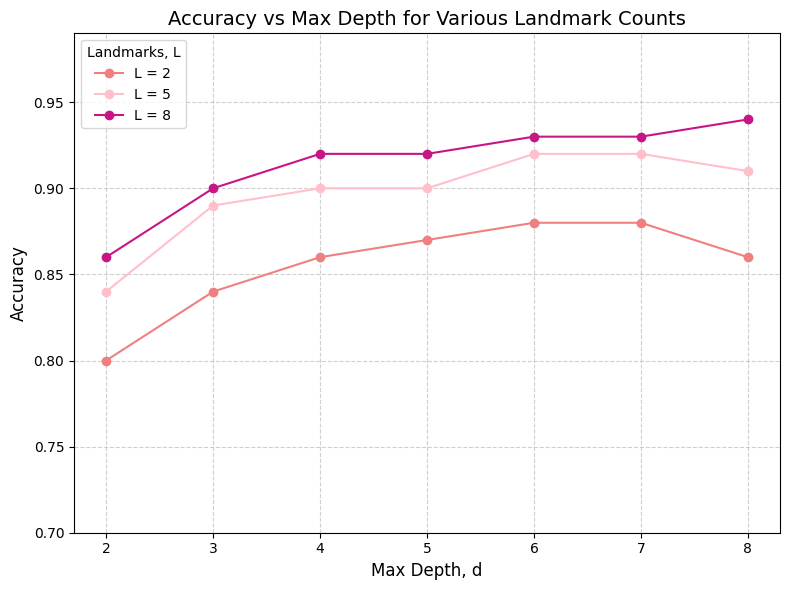

There is no function returning Information Gain. So I just ran the codes multiple times, chaning the parameters, noting down the informaition Gain, and then plotted the values below. 

The depth of the tree here is 4, and the SVM Hyperparameter is 10. 

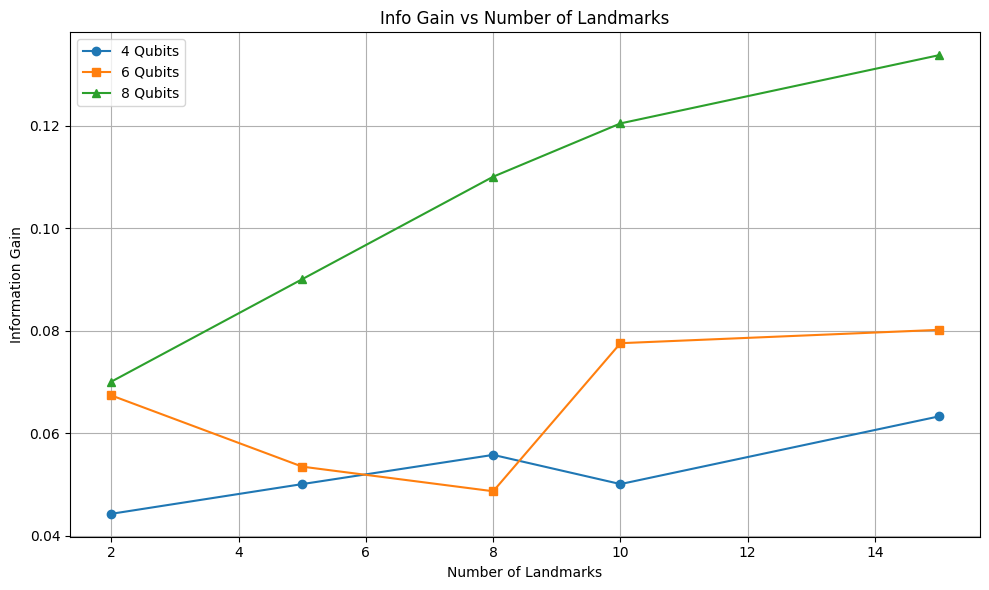

In [4]:
import matplotlib.pyplot as plt

# Landmark values
landmarks = [2, 5, 8, 10, 15]

# Info gain values for different qubit counts
info_gain_4q = [0.0443, 0.0501, 0.0558, 0.0501, 0.0633]
info_gain_6q = [0.0674, 0.0535, 0.0487, 0.0776, 0.0802]
info_gain_8q = [0.0701, 0.0901, 0.1101, 0.1205, 0.1338]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(landmarks, info_gain_4q, marker='o', label='4 Qubits')
plt.plot(landmarks, info_gain_6q, marker='s', label='6 Qubits')
plt.plot(landmarks, info_gain_8q, marker='^', label='8 Qubits')

plt.title('Info Gain vs Number of Landmarks')
plt.xlabel('Number of Landmarks')
plt.ylabel('Information Gain')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Now, we will plot the changes in information gain, during training, while changing the hyperparameter C, which is regularization / penalty parameter of the SVM. So in the training algorithm, the algorithm updates C by multiplying it by 10, after every iteration, till the info gain becomes zero. So, we start off by setting C = 0.01, and the algorithm while training calculates info gain, and increases the value of C 10 times. So I am calculating the average info gain for 3 trees( I have taken the number of trees to be 3) for every C, till it becomes zero. I have only done it for 6 qubits.

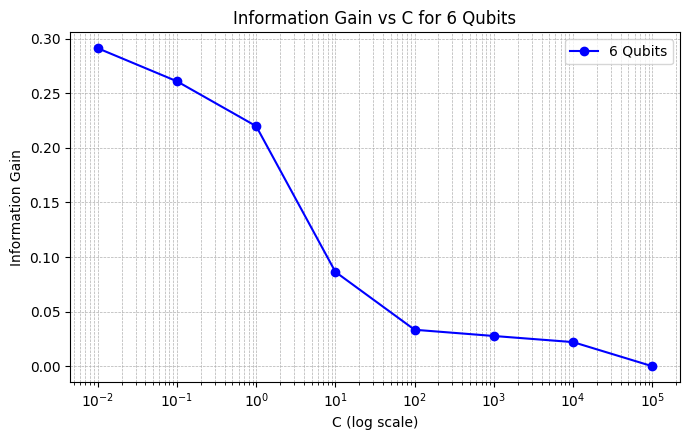

In [7]:
import matplotlib.pyplot as plt
import numpy as np

inv_C_vals = [1e5, 1e4, 1e3, 1e2, 1e1, 1, 1e-1, 1e-2]  # i.e  1e-5 to 1e2
info_gain_6q = [0.0, 0.0221, 0.0277, 0.0334, 0.0864, 0.2199, 0.2610, 0.2913]

# Sort for plotting (x-axis must be increasing)
inv_C_vals = inv_C_vals[::-1]
info_gain_6q = info_gain_6q[::-1]

# Plot
plt.figure(figsize=(7, 4.5))
plt.plot(inv_C_vals, info_gain_6q, label='6 Qubits', marker='o', color='blue')

plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Information Gain')
plt.title('Information Gain vs C for 6 Qubits')
plt.grid(True, which='both', ls='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Experiment settings
tree_counts = list(range(1, 6))                  # num_trees from 1 to 10
partition_sizes = [50, 100, 150]                  # Partition sizes to test

# Constants / hyperparams (your given ones)
n_qubits = 6
dt_type = 'qke'
ensemble_var = None
branch_var = ['eff_anz_pqc_arch', 'iqp_anz_pqc_arch', 'eff_anz_pqc_arch']
split_num = 2
pqc_sample_num = 2024
num_classes = num_classes  # assumed already defined
max_depth = 4
num_params_split = n_qubits * (n_qubits + 1)
num_rand_gen = 1
num_rand_meas_q = n_qubits
svm_num_train = 2
svm_c = 10
min_samples_split = svm_num_train
embedding_type = ['as_params_all', 'as_params_iqp', 'as_params_all']
criterion = SplitCriterion.init_info_gain('clas')
device = 'cirq'

# Store results
results = {}

for part_size in partition_sizes:
    info_gains = []
    for num_trees in tree_counts:
        qrf = QuantumRandomForest(
            n_qubits, 'clas', num_trees, criterion, max_depth=max_depth, 
            min_samples_split=min_samples_split, tree_split_num=split_num, num_rand_meas_q=num_rand_meas_q,
            ensemble_var=ensemble_var, dt_type=dt_type, num_classes=num_classes, ensemble_vote_type='ave',
            num_params_split=num_params_split, num_rand_gen=num_rand_gen, pqc_sample_num=pqc_sample_num,
            embed=embedding_type, branch_var=branch_var, svm_num_train=svm_num_train, svm_c=svm_c, 
            nystrom_approx=True, device=device
        )
        # Set multiprocessing
        cores = 3
        set_multiprocessing(True, cores)
        qrf.train(training_set, partition_sample_size=part_size)

        # Get info gain averaged across trees
        acc, preds_qrf = qrf.test(testing_set, 
                          ret_pred=True, 
                          parallel=False,            # Set to False if you don't want parallel computation. Needs to be False for calc_tree_corr to be True.
                          calc_tree_corr=True) 

    results[part_size] = acc 

# Plot
plt.figure(figsize=(8, 5))
for part_size in partition_sizes:
    plt.plot(tree_counts, results[part_size], marker='o', label=f'Partition size = {part_size}')

plt.xlabel("Number of Trees")
plt.ylabel("Average Information Gain")
plt.title("Info Gain vs Number of Trees for Different Partition Sizes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


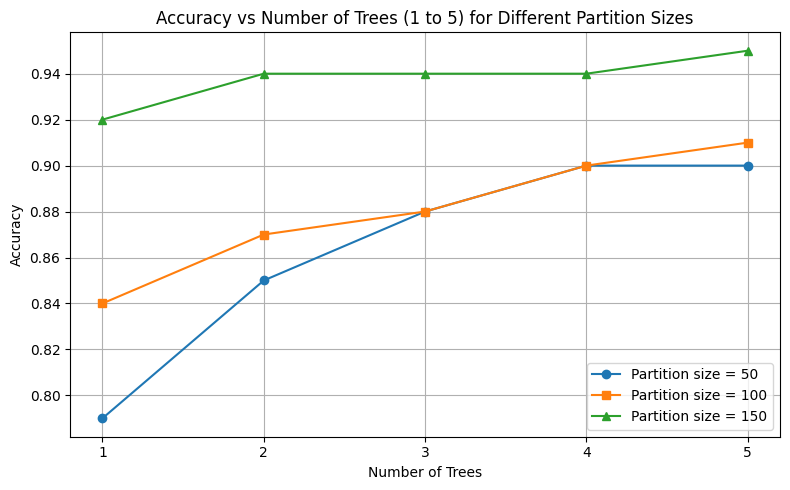